In [5]:
"""Projeto para avalia diferentes modelos de previsão de série temporal."""

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from api import api_requests
from callbacks.utils import data_processing

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

### Obtenção dos dados

In [35]:
data = api_requests.get_atendimentos(None, None, None)
data = data_processing.soma_atendimentos(data)
df = data_processing.get_df_from_json(data)
df

Fazendo request para: https://dash-saude-mongo.elsvital.dev/api/v1/atendimentos


,ano,trimestre,mes,valor,ano_mes,ano_trimestre
0,2013,T2,4,1244,4/2013,T2/2013
1,2013,T3,8,20549,8/2013,T3/2013
2,2013,T4,12,45050,12/2013,T4/2013
3,2013,T3,7,12591,7/2013,T3/2013
4,2013,T2,6,2324,6/2013,T2/2013
...,...,...,...,...,...,...
133,2024,T3,7,33021982,7/2024,T3/2024
134,2024,T2,6,31530970,6/2024,T2/2024
135,2024,T2,5,32572666,5/2024,T2/2024
136,2024,T1,3,32803210,3/2024,T1/2024


### Pré-processamento

In [36]:
from callbacks.utils.forecast import preprocess_sarima_data

df= preprocess_sarima_data(df)
df

,ano_trimestre,ano,trimestre,mes,valor
0,T2/2013,2013,T2,4,1244
1,T2/2013,2013,T2,5,591
2,T2/2013,2013,T2,6,2324
3,T3/2013,2013,T3,7,12591
4,T3/2013,2013,T3,8,20549
...,...,...,...,...,...
132,T2/2024,2024,T2,4,38381846
133,T2/2024,2024,T2,5,32572666
134,T2/2024,2024,T2,6,31530970
135,T3/2024,2024,T3,7,33021982


In [37]:
df = df[['ano', 'mes', 'valor']]

In [38]:
# Filtrar os dados dos últimos 5 anos
df = df[df['ano'] >= 2016]
df

,ano,mes,valor
33,2016,1,8232396
34,2016,2,10104083
35,2016,3,13130885
36,2016,4,11242471
37,2016,5,11755506
...,...,...,...
132,2024,4,38381846
133,2024,5,32572666
134,2024,6,31530970
135,2024,7,33021982


In [39]:
# cria coluna ano-mes
df['ano-mes'] = df['ano'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2)

In [44]:
df.reset_index(drop=True, inplace=True)
df

,ano,mes,valor,ano-mes
0,2016,1,8232396,2016-01
1,2016,2,10104083,2016-02
2,2016,3,13130885,2016-03
3,2016,4,11242471,2016-04
4,2016,5,11755506,2016-05
...,...,...,...,...
99,2024,4,38381846,2024-04
100,2024,5,32572666,2024-05
101,2024,6,31530970,2024-06
102,2024,7,33021982,2024-07


### Separando os dados

In [17]:
# Separar os dados em treino e teste
train = df['valor'][:len(df)-12]
test = df['valor'][len(df)-12:]


### Avaliando com ARIMA

In [19]:
# Avaliar com Arima
model = ARIMA(train, order=(1,1,1))

model_fit = model.fit()

predictions = model_fit.forecast(steps=12)

print('ARIMA')
print('RMSE:', root_mean_squared_error(test, predictions))


ARIMA
RMSE: 3548120.742036189


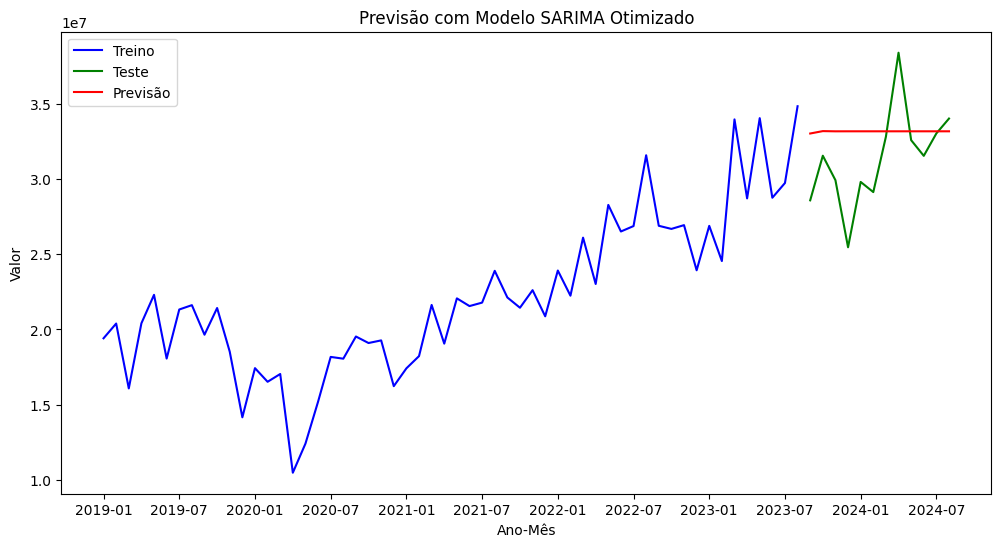

In [21]:
# Visualizar os dados
import matplotlib.pyplot as plt

# Visualizar os dados reais e a previsão
plt.figure(figsize=(12, 6))
plt.plot(df['ano-mes'][:len(df)-12], df['valor'][:len(df)-12],  label='Treino', color='blue')
plt.plot(df['ano-mes'][len(df)-12:], df['valor'][len(df)-12:], label='Teste', color='green')
plt.plot(df['ano-mes'][len(df)-12:], predictions, label='Previsão', color='red')
plt.title('Previsão com Modelo SARIMA Otimizado')
# apresentar os valores no eixo x em intervalos de 4
plt.xticks(df['ano-mes'][::6])
plt.xlabel('Ano-Mês')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Avaliando com SARIMA

In [22]:

# Criar um modelo SARIMA
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Prever os valores
forecast = model_fit.forecast(steps=12)

# Calcular o erro
rmse = root_mean_squared_error(test, forecast)
print(f'RMSE: {rmse}')

mse = mean_squared_error(test, forecast)
print(f'MSE: {mse}')

RMSE: 3375767.3562184544
MSE: 11395805243310.135


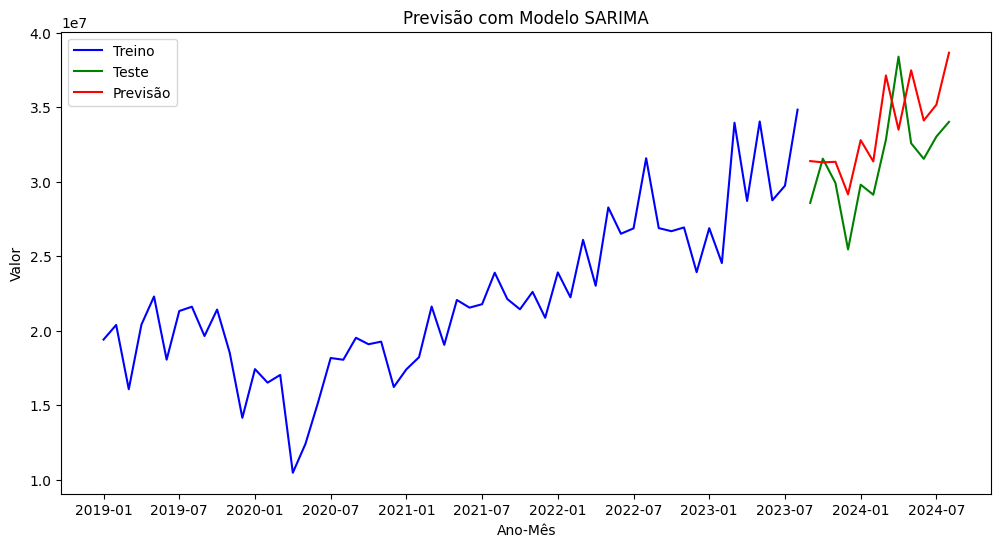

In [23]:
import matplotlib.pyplot as plt

# Visualizar os dados reais e a previsão
plt.figure(figsize=(12, 6))
plt.plot(df['ano-mes'][:len(df)-12], df['valor'][:len(df)-12],  label='Treino', color='blue')
plt.plot(df['ano-mes'][len(df)-12:], df['valor'][len(df)-12:], label='Teste', color='green')
plt.plot(forecast, label='Previsão', color='red')
plt.title('Previsão com Modelo SARIMA')
# apresentar os valores no eixo x em intervalos de 4
plt.xticks(df['ano-mes'][::6])
plt.xlabel('Ano-Mês')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Avaliando outros modelos

In [24]:
# Time Series Forecasting with random forest regressor
from sklearn.ensemble import RandomForestRegressor

# Criar um modelo Random Forest
model = RandomForestRegressor()

# Treinar o modelo
model.fit(train.index.values.reshape(-1, 1), train.values)

# range de valores para prever
index = range(len(train), len(train)+12)

# Reshape para prever
index = pd.Series(index)
index = index.values.reshape(-1, 1)

# Prever os valores
forecast = model.predict(index)

# Calcular o erro
rmse = root_mean_squared_error(test, forecast)
print(f'RMSE: {rmse}')

RMSE: 12428788.07071066


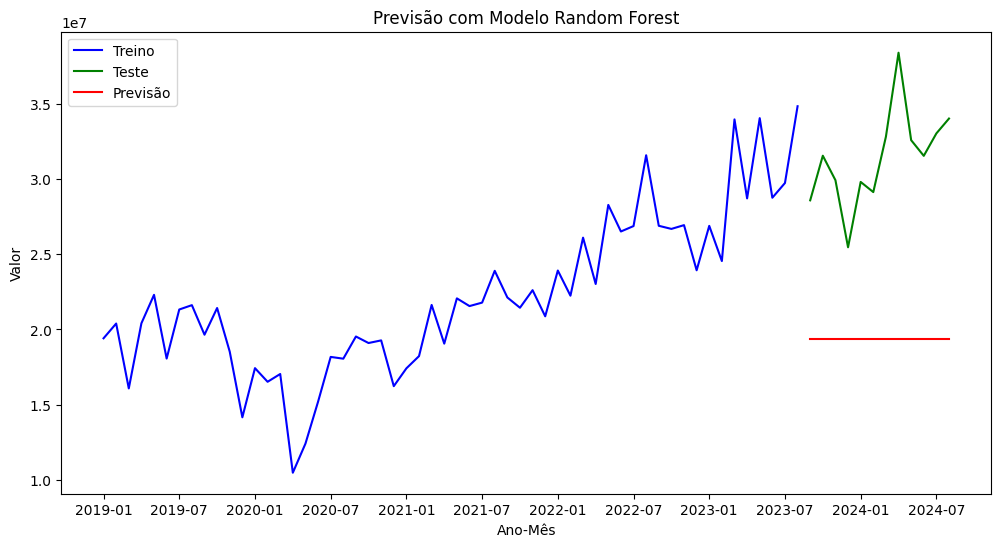

In [26]:
# Visualizar os dados reais e a previsão
plt.figure(figsize=(12, 6))
plt.plot(df['ano-mes'][:len(df)-12], df['valor'][:len(df)-12],  label='Treino', color='blue')
plt.plot(df['ano-mes'][len(df)-12:], df['valor'][len(df)-12:], label='Teste', color='green')
plt.plot(df['ano-mes'][len(df)-12:], forecast, label='Previsão', color='red')
plt.title('Previsão com Modelo Random Forest')
# apresentar os valores no eixo x em intervalos de 4
plt.xticks(df['ano-mes'][::6])
plt.xlabel('Ano-Mês')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [27]:
# Time Series Forecasting with Linear Regression
from sklearn.linear_model import LinearRegression

# Criar um modelo de Regressão Linear
model = LinearRegression()

# Treinar o modelo
model.fit(train.index.values.reshape(-1, 1), train.values)

# Prever os valores
forecast = model.predict(index)

# Calcular o erro
rmse = root_mean_squared_error(test, forecast)
print(f'RMSE: {rmse}')

RMSE: 18305518.252407078


In [28]:
# Time Series Forecasting with Logistic Regression
from sklearn.linear_model import LogisticRegression

# Criar um modelo de Regressão Logística
model = LogisticRegression()

# Treinar o modelo
model.fit(train.index.values.reshape(-1, 1), train.values)

# Prever os valores
forecast = model.predict(index)

# Calcular o erro
rmse = root_mean_squared_error(test, forecast)
print(f'RMSE: {rmse}')

RMSE: 12376860.545397544


### Otimização do SARIMA

In [56]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


# Função para treinar e avaliar o modelo SARIMA
def objective(params):
    # Extrair os parâmetros da busca
    order = (int(params['p']), int(params['d']), int(params['q']))
    seasonal_order = (int(params['P']), int(params['D']), int(params['Q']), 12)  # Sazonalidade de 12 meses
    
    # Treinar o modelo SARIMA
    try:
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        
        # Fazer previsões no conjunto de teste
        predictions = results.predict(start=test.index[0], end=test.index[-1])
        
        # Calcular RMSE
        rmse = np.sqrt(mean_squared_error(test, predictions))
        
        # Retornar o RMSE como a métrica de avaliação
        return {'loss': rmse, 'status': STATUS_OK}
    
    except Exception as e:
        # Se algo falhar, retornar uma perda alta
        return {'loss': 100, 'status': STATUS_FAIL}

# Espaço de busca dos hiperparâmetros
space = {
    'p': hp.quniform('p', 0, 3, 1),
    'd': hp.quniform('d', 0, 2, 1),
    'q': hp.quniform('q', 0, 3, 1),
    'P': hp.quniform('P', 0, 3, 1),
    'D': hp.quniform('D', 0, 2, 1),
    'Q': hp.quniform('Q', 0, 3, 1)
}

# Função de otimização
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Melhor conjunto de hiperparâmetros
print("Best parameters:", best_params)

# order(2, 0, 3), seasonal_order(1, 1, 2, 12)
# order(3, 0, 1), seasonal_order(0, 1, 1, 12)

100%|██████████| 50/50 [03:07<00:00,  3.75s/trial, best loss: 4544470.757873817]
Best parameters: {'D': 1.0, 'P': 3.0, 'Q': 3.0, 'd': 1.0, 'p': 0.0, 'q': 2.0}


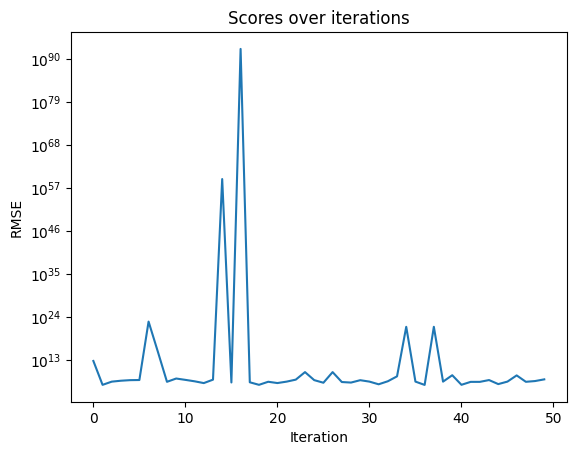

In [57]:
# plot the trials objective scores in log scale
import matplotlib.pyplot as plt

scores = [trial['result']['loss'] for trial in trials.trials]
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('Scores over iterations')
plt.show()

In [58]:
# Avaliar o modelo com os melhores hiperparâmetros
order = (int(best_params['p']), int(best_params['d']), int(best_params['q']))
seasonal_order = (int(best_params['P']), int(best_params['D']), int(best_params['Q']), 12)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
predictions = results.predict(start=test.index[0], end=test.index[-1])

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

RMSE: 4544470.757873817


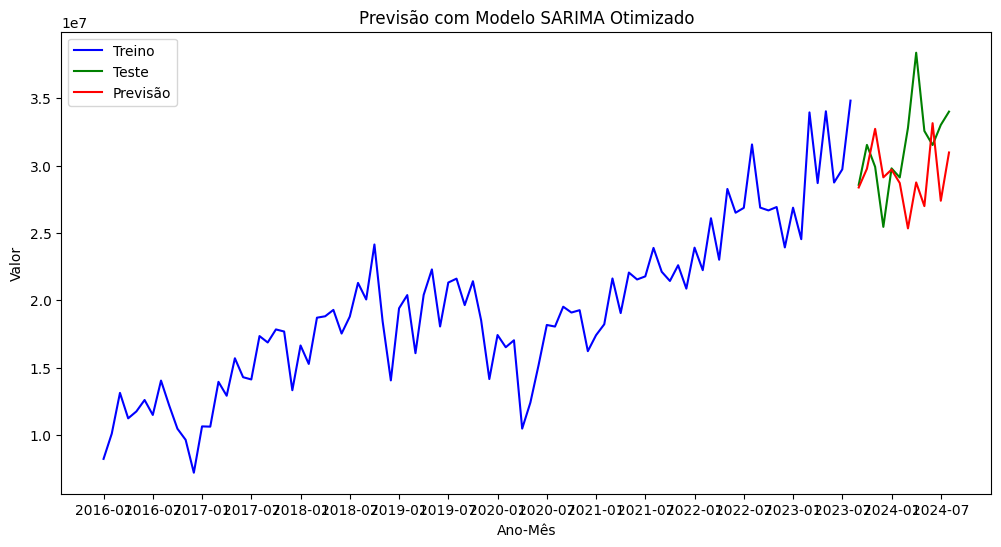

In [59]:
# Visualizar os dados reais e a previsão
plt.figure(figsize=(12, 6))
plt.plot(df['ano-mes'][:len(df)-12], df['valor'][:len(df)-12],  label='Treino', color='blue')
plt.plot(df['ano-mes'][len(df)-12:], df['valor'][len(df)-12:], label='Teste', color='green')
plt.plot(df['ano-mes'][len(df)-12:], predictions, label='Previsão', color='red')
plt.title('Previsão com Modelo SARIMA Otimizado')
# apresentar os valores no eixo x em intervalos de 4
plt.xticks(df['ano-mes'][::6])
plt.xlabel('Ano-Mês')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Conclusão

Primeiro modelo testado com SARIMA apresentou melhores resultados, com RMSE de 3.375.767 enquanto o hyperopt encontrou um RMSE de 4.544.470.
